# Introduction 

In June 2020, researchers at Meta released the Wav2Vec2 model, using a BERT-like self-supervised representation learning method. At a high-level, this includes a large-scale self-supervised pretraining phase, followed by supervised finetuning on a smaller dataset. The model was trained on the LibriSpeech dataset, a corpus of English-read speech. There is little information about the demogrpahic backgrounds of the speakers. It is probably safe to assume that they fit characteristics of the imagined native English speaker. Indeed, the model achives the best performance on monolingual English speakers (see Figure below). Under this presumable demographic composition, the model is unlikely to achieve comparable performance for bilingual speakers, especially those who speak a different first language. 

Almost exactly three years later, Meta released the MMS model, which contends to scale Speech Technology to 1,000+ Languages. This statement implies a sort of capture... [TO DO]. This conceptual model clearly does not work, as the model still struggles to capture English speech from bilingual speakers, still obtaining high error rates especially for [X], [X], and [X] backgrounds. On this dataset, the error rates between the models remain highly correlated. 


# SpeechBox dataset
## Backgrounds

In [2]:
CODE_2_BACKGROUNDS = {
    "CCT": "Cantonese", 
    "CMN": "Mandarin, Mainland", 
    "CSP": "Mandarin, Singaporean", 
    "CTW": "Mandarin, Taiwanese", 
    "ENG": "English",
    "FAR": "Farsi", 
    "FRA": "French", 
    "GER": "German", 
    "GIS": "Gishu", 
    "GRE": "Greek", 
    "GUJ": "Gujurati", 
    "HEB": "Hebrew", 
    "HIN": "Hindi",
    "ICE": "Icelandic", 
    "IND": "Indonesian", 
    "JPN": "Japanese", 
    "KOR": "Korean", 
    "MLY": "Malay",
    "PBR": "Brazilian Portuguese", 
    "RUN": "Runyankore", 
    "RUS": "Russian", 
    "SHS": "Spanish Heritage Speakers", 
    "SPA": "Spanish", 
    "THA": "Thai", 
    "TUR": "Turkish", 
    "VIE": "Vietnamese"
}

## Example samples

In [3]:
import math
import numpy as np
import librosa
from praatio import textgrid
import os
from pathlib import Path
import IPython.display as ipd

TARGET_SAMPLING_RATE=16000

backgrounds_slices = []
for dirname in list(filter(lambda x: x.endswith("DHR"), os.listdir("allsstar/2152"))):
    speechbox_subdir = f"allsstar/2152/{dirname}"
    identifiers = set([Path(dir_fname).stem for dir_fname in os.listdir(speechbox_subdir)])
    for identifier in identifiers:
        tg = textgrid.openTextgrid(f"{speechbox_subdir}/{identifier}.TextGrid", False)
        nid = identifier.split('_')[1]
        entries = tg.getTier('utt').entries
        data, _ = librosa.load(f"{speechbox_subdir}/{identifier}.wav", sr=TARGET_SAMPLING_RATE, dtype=np.float64)
        for i in range(len(entries)):
            first_interval_start, first_interval_end = entries[i].start, entries[i].end
            label = entries[i].label
            slice = data[math.floor(first_interval_start * TARGET_SAMPLING_RATE): math.ceil(first_interval_end * TARGET_SAMPLING_RATE)]
            background = identifier.split('_')[3]
            backgrounds_slices.append((background, slice))
            break
        break

In [4]:
backgrounds_slices[0]

('FAR',
 array([-3.95128913e-04, -2.07015174e-04, -2.54885925e-04, ...,
         5.77361153e-06,  1.11512716e-04,  1.54265177e-04]))

In [5]:
import ipywidgets as widgets
# print("hello")
# ipd.display(ipd.Audio(slices[0], rate=16000))
# print("hello")
# ipd.display(ipd.Audio(slices[1], rate=16000))
out = widgets.Output(layout={'border': '1px solid black'})
for i in range(len(backgrounds_slices)):
    out.append_stdout(f"{CODE_2_BACKGROUNDS[backgrounds_slices[i][0]]}")
    out.append_display_data(ipd.Audio(backgrounds_slices[i][1], rate=16000))
out
# ipd.Audio(slices[0], rate=16000)
# ipd.Audio(slices[1], rate=16000)

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

In [6]:
import polars as pl
from evaluate import load

/Users/smfsamir/mac_env/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [7]:
from jiwer import wer
import string

def add_wer_column(frame):
    translator = str.maketrans('', '', string.punctuation)
    return frame.with_columns([
        pl.struct(['transcription_prediction', 'gt_transcript'])\
            .map_elements(lambda row: wer(
                row['gt_transcript'].lower().translate(translator),
                row['transcription_prediction'].lower().translate(translator)
            )).alias('wer')
    ])

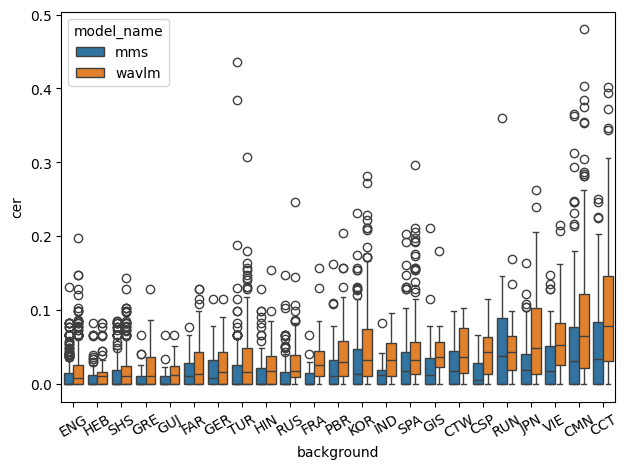

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau, spearmanr, pearsonr

def preprocess_frame(frame):
    frame = add_wer_column(frame)
    return frame.filter(pl.col('cer') < 0.5) # probably a transcript alignment problem
wavlm_frame = preprocess_frame(pl.read_csv('wavlm_speechbox_dhr_frame.tsv', separator='\t'))
mms_frame = preprocess_frame(pl.read_csv('mms_speechbox_dhr_frame.tsv', separator='\t'))
whisper_frame = preprocess_frame(pl.read_csv('whisper_speechbox_dhr_frame.tsv', separator='\t'))


def get_sorted_worst_backgrounds(frame):
    return frame.group_by(pl.col('background')).agg(pl.col('cer').median()).sort('cer', descending=False)['background'].to_list()

def convert_to_indices(backgrounds):
    alphabetical = sorted(backgrounds)
    actual_order = [alphabetical.index(background) for background in backgrounds]
    return actual_order

def add_model_name_column(frame, model_name):
    return frame.with_columns(
        pl.lit(model_name).alias('model_name')
    )

wavlm_worst = get_sorted_worst_backgrounds(wavlm_frame)
mms_worst = get_sorted_worst_backgrounds(mms_frame)
whisper_worst = get_sorted_worst_backgrounds(whisper_frame)
vis_frame = pl.concat([
    add_model_name_column(mms_frame, 'mms'), 
    add_model_name_column(wavlm_frame, 'wavlm')
    ])
# print(kendalltau(mms_worst, wavlm_worst))

sns.boxplot(vis_frame, x='background', y='cer', hue='model_name', order=(wavlm_worst))
plt.xticks(rotation=30)
plt.tight_layout()

In [9]:
joined = mms_frame.join(wavlm_frame, on=['nid', 'timestamp'], suffix='_wavlm')
pearson = pearsonr(joined['cer'], joined['cer_wavlm'])
print(f"MMS-WavLM CER Pearson correlation: {pearson.statistic:.3f}")

MMS-WavLM CER Pearson correlation: 0.745


In [20]:
joined

timestamp,gender,transcription_prediction,background,gt_transcript,nid,cer,wer,gender_wavlm,transcription_prediction_wavlm,background_wavlm,gt_transcript_wavlm,cer_wavlm,wer_wavlm
str,str,str,str,str,i64,f64,f64,str,str,str,str,f64,f64
"""00:00.183000-0…","""M""","""no one shall b…","""SPA""","""no one shall b…",123,0.0,0.0,"""M""","""NO ONE SHALL B…","""SPA""","""no one shall b…",0.010753,0.125
"""00:07.878000-0…","""M""","""everyone has t…","""SPA""","""everyone has t…",123,0.0,0.0,"""M""","""EVERYONE HAS T…","""SPA""","""everyone has t…",0.0,0.0
"""00:12.879000-0…","""M""","""everyone has t…","""SPA""","""everyone has t…",123,0.07377,0.157895,"""M""","""EVERYONE HAS T…","""SPA""","""everyone has t…",0.02459,0.052632
"""00:21.564000-0…","""M""","""everyone has t…","""SPA""","""everyone has t…",123,0.0,0.0,"""M""","""EVERYONE HAS T…","""SPA""","""everyone has t…",0.0,0.0
"""00:26.580000-0…","""M""","""every one has …","""SPA""","""everyone has t…",123,0.011111,0.117647,"""M""","""EVERY ONE HAS …","""SPA""","""everyone has t…",0.011111,0.117647
"""00:32.802000-0…","""M""","""everyone has t…","""SPA""","""everyone has t…",123,0.0,0.0,"""M""","""EVERY ONE HAS …","""SPA""","""everyone has t…",0.025641,0.285714
"""00:35.647000-0…","""M""","""no one shall b…","""SPA""","""no one shall b…",123,0.0,0.0,"""M""","""NO ONE SHALL B…","""SPA""","""no one shall b…",0.0,0.0
"""00:39.340000-0…","""M""","""everyone has t…","""SPA""","""everyone has t…",123,0.0,0.0,"""M""","""EVERY ONE HAS …","""SPA""","""everyone has t…",0.02439,0.2
"""00:45.246000-0…","""M""","""everyone has t…","""SPA""","""everyone has t…",123,0.0,0.0,"""M""","""EVERY ONE HAS …","""SPA""","""everyone has t…",0.043956,0.235294


# Specific examples of bad transcriptions

Here, we add 5 examples from each of the top 5 most badly transcribed dialect backgrounds.

In [30]:
import math
def convert_timestamps_to_sample_index(timestamp, sampling_rate=16000):
    timestamp_mm = int(timestamp.split(':')[0])
    timestamp_ss = timestamp.split(':')[1] # don't need hour marker

    return (float(timestamp_mm * 60) + float(timestamp_ss)) * sampling_rate

def convert_timestamp_to_sample_range(timestamp_full):
    print(timestamp_full)
    timestamp_start = timestamp_full.split("-")[0]
    timestamp_end = timestamp_full.split("-")[1]
    return (math.floor(convert_timestamps_to_sample_index(timestamp_start)), math.ceil(convert_timestamps_to_sample_index(timestamp_end)))

def retrieve_recording(background: str, nid: int, timestamp):
    background_dirs = list(filter(lambda x: x.endswith(f"{background}_ENG_DHR"), os.listdir("allsstar/2152")))
    assert len(background_dirs) == 1
    background_dir = background_dirs[0]
    speechbox_subdir = f"allsstar/2152/{background_dir}"
    filenames = list(filter(lambda x: (str(nid) in x) and (x.endswith(".wav")), os.listdir(speechbox_subdir)))
    assert len(filenames) == 1
    filename = filenames[0]
    data, _ = librosa.load(f"{speechbox_subdir}/{filename}", sr=TARGET_SAMPLING_RATE, dtype=np.float64)
    sample_timestamp_start, sample_timestamp_end = convert_timestamp_to_sample_range(timestamp)
    return data[sample_timestamp_start:sample_timestamp_end]

def retrieve_top_n_samples(frame: pl.DataFrame, worst_backgrounds_by_cer, cer_column, n=5):
    return frame.filter(pl.col('background').is_in(worst_backgrounds_by_cer))\
        .sort(cer_column, descending=True)\
        .with_columns([
            pl.int_range(0, pl.count()).over('background').alias('rank')
        ]).filter(pl.col('rank') < n)\
        .drop('rank')

def display_top_n_samples(frame, background):
    out = widgets.Output(layout={'border': '1px solid black'})
    out.append_stdout(f"==={background.upper()}===\n")
    for i, row in enumerate(frame.filter(pl.col('background')==background).iter_rows(named=True)):
        transcript = row['transcription_prediction_wavlm']
        mms_transcript = row['transcription_prediction']
        gt_transcript = row['gt_transcript']
        recording = retrieve_recording(background, row['nid'], row['timestamp']) 
        out.append_stdout(f"{i+1}.\nScript: {gt_transcript}\nWavLM: {transcript.lower()}\nMMS: {mms_transcript}")
        out.append_display_data(ipd.Audio(recording, rate=16000))
    return out

wavlm_top_n_frame = retrieve_top_n_samples(joined,  wavlm_worst[-5:], 'cer_wavlm')
for background in reversed(wavlm_worst[-5:]):
    display(display_top_n_samples(wavlm_top_n_frame, background))

# retrieve_top_n_samples(wavlm_frame, wavlm_worst)
# recording = retrieve_recording(joined['background'][0], joined['nid'][0], joined['timestamp'][0])
# retrieve_top_n_samples(wavlm_frame, wavlm_worst[-5:])


01:12.313000-01:21.013000
01:37.982000-01:47.851000
00:59.439000-01:11.668000
00:53.563000-01:02.182000
02:51.723000-02:59.752000


Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

00:20.315000-00:25.305000
00:34.734000-00:37.754000
01:46.698000-01:50.948000
00:00.193000-00:06.652000
00:49.493000-00:55.373000


Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

00:54.070000-01:02.189000
02:22.290000-02:29.410000
01:47.843000-02:06.013000
00:00.173000-00:08.372000
02:29.926000-02:35.127000


Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

01:23.067000-01:28.007000
01:33.660000-01:39.850000
00:57.916000-01:04.515000
00:40.536000-00:44.485000
00:09.505000-00:14.674000


Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

01:15.470000-01:22.049000
01:47.402000-01:52.901000
01:35.655000-01:41.315000
00:41.404000-00:44.815000
00:26.762000-00:33.742000


Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

# Analysis

[] We see that both models have a propensity to transcribe in a near-phonetic fashion, consider, for example,   
    [] Add (at least) one example from each.
    [] On the one hand, this seems perhaps appropriate, but... [lingustic racism]
    [] Also, English is highly phonetically not transparent, but the model knows how to transcribe it.
        [] Also, it doesn't encode phonological distinctions for the native speaker, but does for others?
[] Also worth noting that WavLM still gets nearly 2M downloads per month


# Conclusion

[] Can we expect the massive-pretraining to get better at capturing marginalized voices? Or is it more likely that we consider people whose voices are poorly captured as not speaking the language correctly? There are examples of this from scholars...